In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maqsoodahmed110","key":"626f2c292d2debb61fe4b4468a83b90d"}'}

In [2]:
!pip install kaggle  # Install Kaggle CLI
!mkdir -p ~/.kaggle  # Create a directory for Kaggle API
!mv kaggle.json ~/.kaggle/  # Move kaggle.json to the correct folder
!chmod 600 ~/.kaggle/kaggle.json  # Secure permissions


In [3]:

#!/bin/bash
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


In [4]:
!unzip /content/asl-alphabet.zip -d asl_alphabet_data


Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  

In [5]:
!pip install torch torchvision matplotlib shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import shap
import os
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


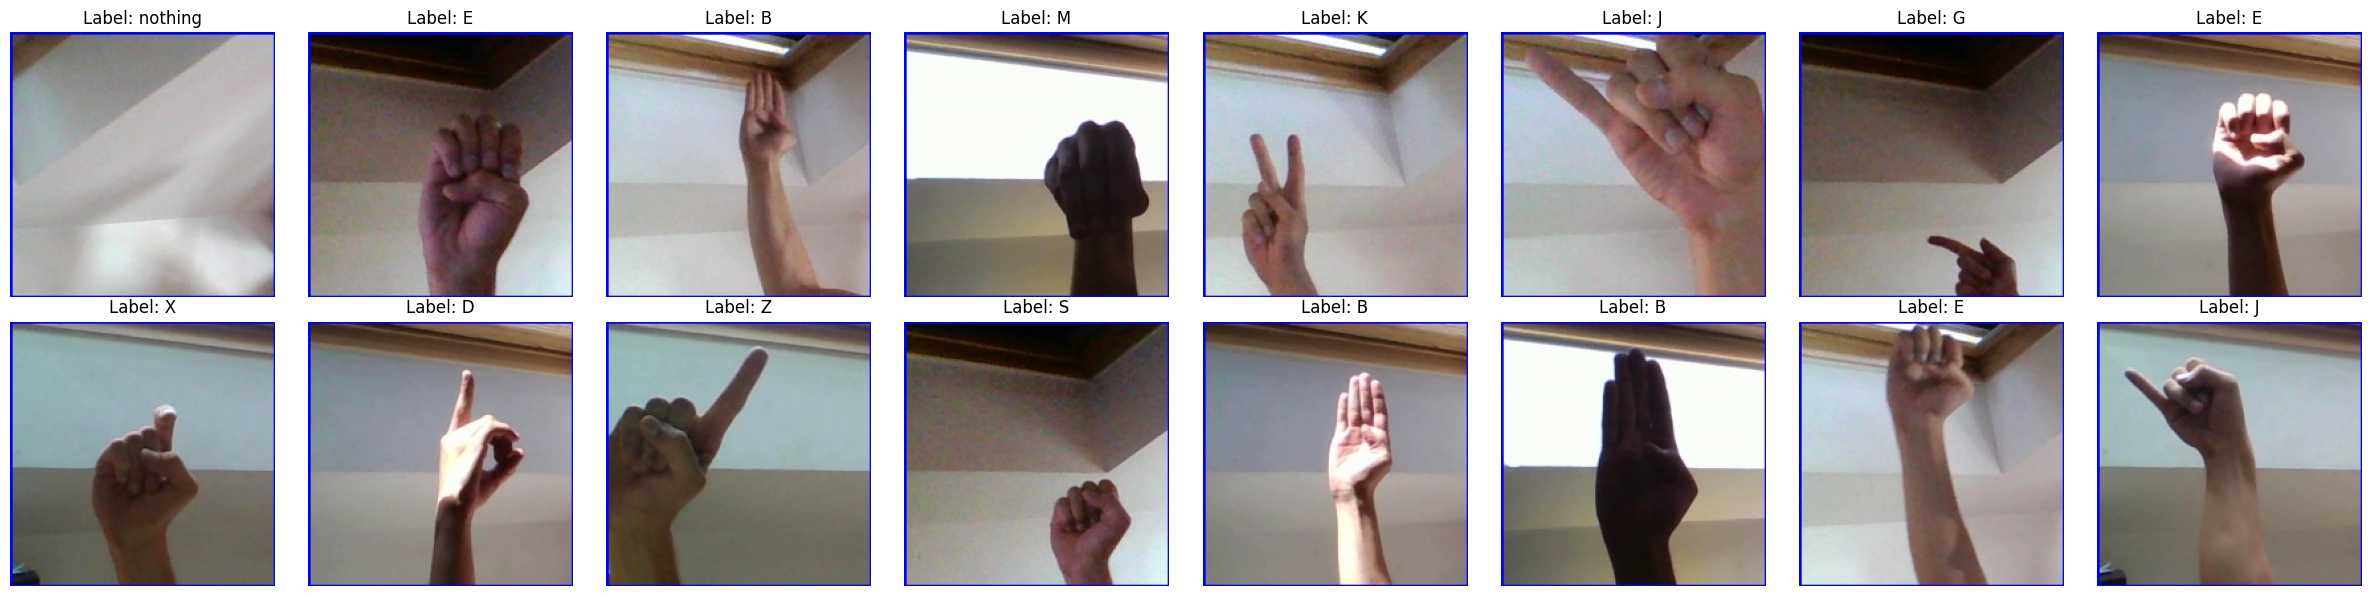

In [7]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

# Define the dataset path
train_dir = "/content/asl_alphabet_data/asl_alphabet_train/asl_alphabet_train"

# Initialize lists for image paths and labels
image_paths = []
labels = []

# Loop through each class folder (A-Z, SPACE, DELETE, NOTHING)
for class_label in sorted(os.listdir(train_dir)):
    class_dir = os.path.join(train_dir, class_label)

    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_label)

# Select random images to display (max 16)
num_samples = min(16, len(image_paths))
selected_indices = random.sample(range(len(image_paths)), num_samples)

# Set up the plot
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6))
axes = axes.flatten()

# Display images
for idx, img_idx in enumerate(selected_indices):
    img_path = image_paths[img_idx]
    label = labels[img_idx]

    try:
        image = Image.open(img_path).convert("RGB")
        axes[idx].imshow(image)
        axes[idx].set_title(f"Label: {label}", fontsize=12)
        axes[idx].axis("off")
    except UnidentifiedImageError:
        print(f"Corrupted or invalid image skipped: {img_path}")
        axes[idx].axis("off")

# Hide unused axes if fewer than 16 images
for idx in range(num_samples, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


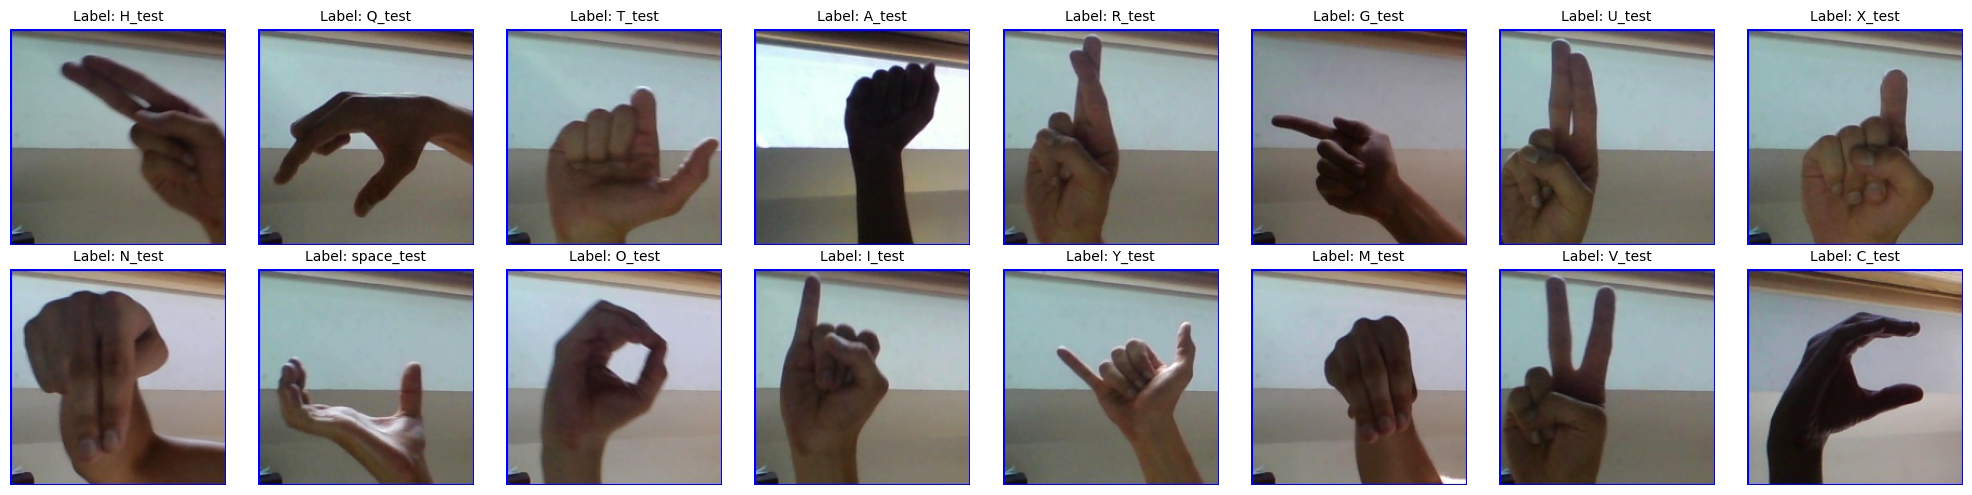

In [8]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Correct test directory path
test_dir = "/content/asl_alphabet_data/asl_alphabet_test/asl_alphabet_test"

# Lists to store paths and labels
image_paths = []
labels = []

# Read all images directly (no subfolders)
for img_name in sorted(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_name)
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(img_path)
        labels.append(os.path.splitext(img_name)[0])  # Remove .jpg extension for label

# Pick 16 random images
num_samples = min(16, len(image_paths))
selected_indices = random.sample(range(len(image_paths)), num_samples)

# Plot setup
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
axes = axes.flatten()

for i, idx in enumerate(selected_indices):
    img_path = image_paths[idx]
    label = labels[idx]

    try:
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis("off")
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        axes[i].axis("off")

# Hide extra axes
for j in range(num_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
!ls /content/asl_alphabet_data


asl_alphabet_test  asl_alphabet_train


In [10]:
!ls /content/asl_alphabet_data/asl_alphabet_test/asl_alphabet_test


A_test.jpg  G_test.jpg	M_test.jpg	  R_test.jpg	  W_test.jpg
B_test.jpg  H_test.jpg	nothing_test.jpg  space_test.jpg  X_test.jpg
C_test.jpg  I_test.jpg	N_test.jpg	  S_test.jpg	  Y_test.jpg
D_test.jpg  J_test.jpg	O_test.jpg	  T_test.jpg	  Z_test.jpg
E_test.jpg  K_test.jpg	P_test.jpg	  U_test.jpg
F_test.jpg  L_test.jpg	Q_test.jpg	  V_test.jpg


In [11]:
!ls /content/asl_alphabet_data/asl_alphabet_train/asl_alphabet_train

A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


In [12]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset path
train_dir = "/content/asl_alphabet_data/asl_alphabet_train/asl_alphabet_train"

# Load training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Split train dataset into train and validation (e.g. 90% train, 10% val)
from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_loader.dataset.dataset.classes  # dataset inside random_split
print(f"Classes: {class_names}")


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [13]:
# Load ResNet-50 with modified final layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0
    scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training

    # To store metrics for plotting
    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed Precision Forward Pass
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation with GradScaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute Training F1-score
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_train_loss = running_loss / len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # Learning Rate Scheduling
        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f} | Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break

    # Plotting Loss and F1-Score graphs
    epochs_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()

    # Plot F1-Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_f1_scores, label='Train F1 Score')
    plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Epoch vs F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


<ipython-input-15-491d8130f522>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training
Epoch 1/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Validation]: 100%|██████████| 272/272 [00:47<00:00,  5.70it/s]


Epoch 1/10: Train Loss: 0.0938, Train F1: 0.9795 | Val Loss: 0.0061, Val F1: 0.9985


Epoch 2/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.85it/s]


Epoch 2/10: Train Loss: 0.0190, Train F1: 0.9952 | Val Loss: 0.0108, Val F1: 0.9969


Epoch 3/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.88it/s]


Epoch 3/10: Train Loss: 0.0137, Train F1: 0.9963 | Val Loss: 0.0150, Val F1: 0.9954


Epoch 4/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.90it/s]


Epoch 4/10: Train Loss: 0.0114, Train F1: 0.9971 | Val Loss: 0.0038, Val F1: 0.9991


Epoch 5/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.81it/s]


Epoch 5/10: Train Loss: 0.0084, Train F1: 0.9979 | Val Loss: 0.0080, Val F1: 0.9975


Epoch 6/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.90it/s]


Epoch 6/10: Train Loss: 0.0086, Train F1: 0.9976 | Val Loss: 0.0009, Val F1: 1.0000


Epoch 7/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.86it/s]


Epoch 7/10: Train Loss: 0.0071, Train F1: 0.9982 | Val Loss: 0.0012, Val F1: 0.9997


Epoch 8/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.88it/s]


Epoch 8/10: Train Loss: 0.0053, Train F1: 0.9985 | Val Loss: 0.0012, Val F1: 0.9999


Epoch 9/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.83it/s]


Epoch 9/10: Train Loss: 0.0042, Train F1: 0.9990 | Val Loss: 0.0009, Val F1: 0.9998


Epoch 10/10 [Training]:   0%|          | 0/2447 [00:00<?, ?it/s]<ipython-input-15-491d8130f522>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/10 [Validation]: 100%|██████████| 272/272 [00:46<00:00,  5.84it/s]


Epoch 10/10: Train Loss: 0.0062, Train F1: 0.9984 | Val Loss: 0.0083, Val F1: 0.9977


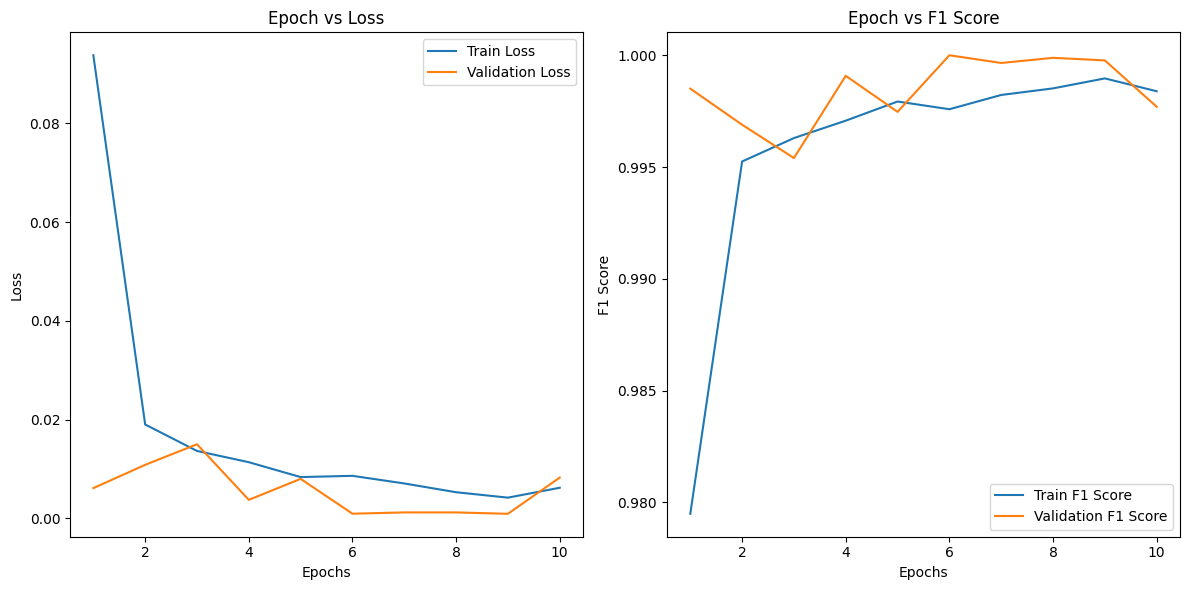

In [16]:
# Now you can call the function to train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


In [32]:
import os
import shutil
test_dir = "/content/asl_alphabet_data/asl_alphabet_test/asl_alphabet_test"

# Remove the '.ipynb_checkpoints' folder if it exists
if os.path.exists(os.path.join(test_dir, '.ipynb_checkpoints')):
    shutil.rmtree(os.path.join(test_dir, '.ipynb_checkpoints'))

for file in os.listdir(test_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        label = file.split('_')[0]  # e.g., A_test.jpg → A
        label_dir = os.path.join(test_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.move(os.path.join(test_dir, file), os.path.join(label_dir, file))

In [33]:
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
print(f"Class Names: {class_names}")

Class Names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [34]:
print(f"Detected class names: {test_dataset.classes}")
print(f"Class to index mapping: {test_dataset.class_to_idx}")


Detected class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Evaluating Model: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Test Loss: 0.0017

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      

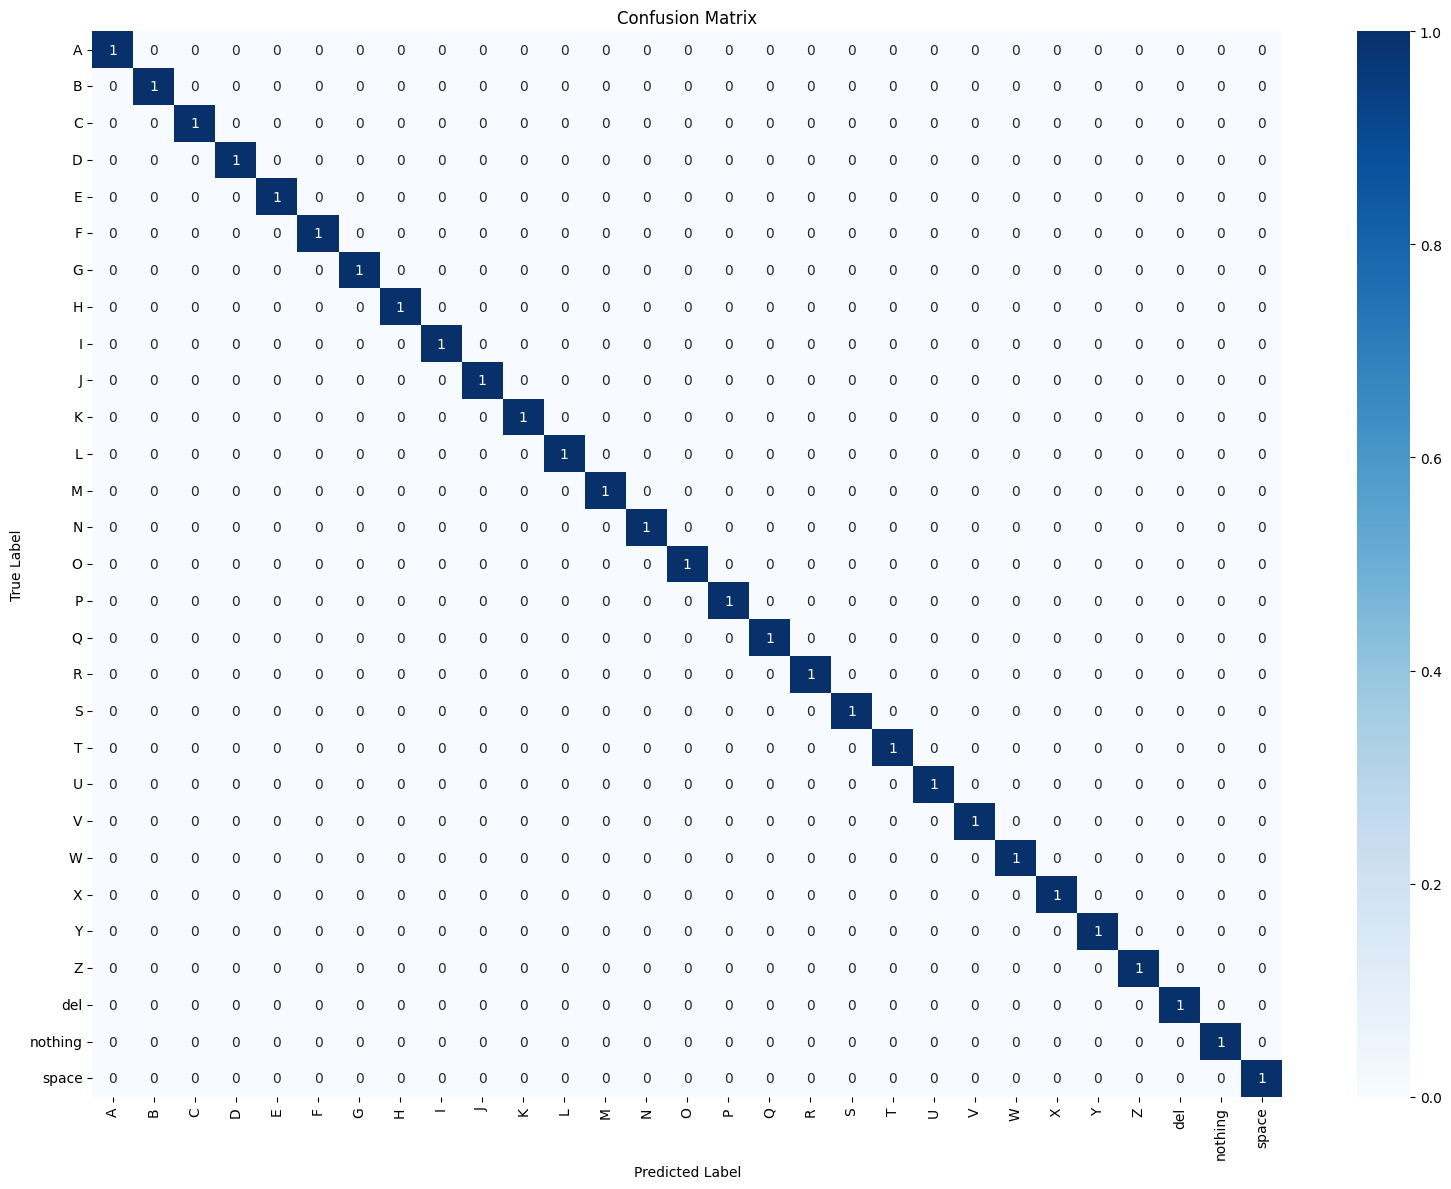

In [36]:
evaluate_model(model, test_loader, criterion, class_names)


In [37]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image(image_path, model, class_names):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image and model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class


In [38]:
image_path = "/content/L.jpg"  # Change this to your image path
predicted_label = predict_image(image_path, model, class_names)
print(f"Predicted Label: {predicted_label}")


Predicted Label: L


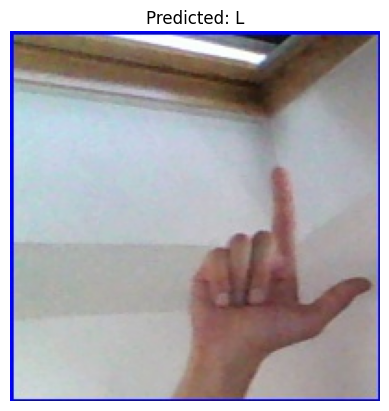

In [39]:
import matplotlib.pyplot as plt

def show_prediction(image_path, predicted_label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Show the prediction
show_prediction(image_path, predicted_label)


In [40]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00


In [41]:
import gradio as gr
from PIL import Image

# Load the saved model
model.load_state_dict(torch.load("/content/best_model.pth", map_location=torch.device('cpu')))
model.eval()

# Prediction function
def predict_gradio(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)  # [1, 3, 224, 224]

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_label = class_names[predicted.item()]

    return predicted_label


In [42]:
interface = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="pil"),
    outputs="label",
    title="ASL Alphabet Sign Prediction",
    description="Upload a hand sign image to predict the corresponding ASL alphabet."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d07fc8b39ce8182961.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [44]:
pip install torchsummary


In [45]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [46]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 